In [1]:
import pandas as pd
import numpy as np 

In [118]:
datapath = r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData_metrologicalData.csv"
# read data
Df = pd.read_csv(datapath)
df = Df.copy()

In [3]:
selectedStation = "#Stockholm Torkel Knutssongatan"

## selecting station
df = df.loc[df['Station Name'] == selectedStation]

## convert columns to date
df['DateTimestamp'] = pd.to_datetime(df['DateTimestamp'])


### Adding new Features
## Generating weektype from day of week
df['Weektype'] = pd.DatetimeIndex(df['DateTimestamp']).dayofweek
# Replace weedays labels WeekDays and WeekEnds 
df['Weektype'] = df['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
df['Weektype'] = df['Weektype'].replace([5, 6], 'WeekEnd')

## Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
df = df.assign(Hour=pd.cut(df['DateTimestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
# Replace timestamp 00:00 with Transition
df['Hour'] = df['Hour'].fillna('Transition')
df['Hour'] = df.Hour.astype(str)

In [4]:
def removeOutliersUsingIsolationForest(df):
    
    print('Removing Oultiers: \n')
    ## required library
    from sklearn.ensemble import IsolationForest
    
    ## value to replace nan
    nanReplaceValue = min(df[['NO2','NOX as NO2','PM2.5','PM10']].min())-0.00001
    
    ## remove warning
    pd.set_option('mode.chained_assignment', None)

    ### Removing Outliers based on individual spatial classes
    ## replace na with zero
    df_1 = df.fillna(nanReplaceValue)

    ## IsolationForest parameter
    clf=IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', \
                            max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)

    cfilt = list(df_1['Classification'].unique())
    wfilt = list(df_1['Weektype'].unique())
    hfilt = list(df_1['Hour'].unique())

    df_2 = pd.DataFrame(columns = ['DateTimestamp','Station Name','Classification',
                                   'Weektype','Hour','NO2', 'NOX as NO2','PM2.5', 'PM10'])

    for clvl in cfilt:
        for wlvl in wfilt:
            for hlvl in hfilt:

                print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
                print(len(df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
                temp = df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')

                # detect Outliers
                to_model_columns=temp[['NO2','NOX as NO2','PM2.5','PM10']].columns
                # fiting data
                clf.fit(temp[to_model_columns])
                # predicting ouliers
                pred = clf.predict(temp[to_model_columns])
                # marking outliers
                temp['anomaly'] = pred
                outliers=temp.loc[temp['anomaly']==-1]
                #outlier_index=list(outliers.index)

                # number of anomalies(-1) and normal points(1)
                print(temp['anomaly'].value_counts())
                df_2 = df_2.append(temp)
                print('Appended\n')

    ## revert  to nan            
    to_model_columns = ['NO2', 'NOX as NO2','PM2.5', 'PM10']
    df_2[to_model_columns] = df_2[to_model_columns].replace(nanReplaceValue,np.nan)
    print(df_2.info())

    # selecting non-anomaly 
    df_3 = df_2[df_2['anomaly'] == 1]
    df_3 = df_3.drop(['anomaly'],axis = 1)
    print(df_3.info())
  
    return(df_3)

In [5]:
OutlierRemoval = False
if OutlierRemoval == True:
    df = removeOutliersUsingIsolationForest(df)


In [6]:
selectedFeatures = ['DateTimestamp','Classification','Weektype','Hour','NOX as NO2','PM10',
                    'Air pressure','Air temperature', 'Amount of clouds', 'Precipitation amount',
                    'Wind direction', 'Wind speed']

## onehot encoding catergories column
df = pd.get_dummies(df[selectedFeatures])

In [7]:
# Generating Year
df['Year'] = df['DateTimestamp'].dt.year

# dropping 2020 data
df = df[df['Year'] != 2020]

# defining the length of the train and test 
train_len = df.loc[df['Year'].isin([2015,2016,2017])].shape[0]
print('Train:',df.loc[df['Year'].isin([2015,2016,2017])].shape[0])
print('Test: ',df.loc[df['Year'].isin([2018,2019])].shape[0])

Train: 26303
Test:  17520


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## Modyfying data for training LSTM 
# selecting PM10 column
data_set  = df.iloc[:,1:len(df.columns)].values
data_set  = data_set.reshape(-1,len(df.columns)-1)
print("Data Set:\n",data_set[0])
print("Shape:\n",data_set.shape)
print()

# Normalisation of Data
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(data_set)
print("Normalised Data Set:\n",data_set_scaled[0])
print()

# replace nan with -0.00001
data_set_scaled[np.isnan(data_set_scaled)] = -0.00001

# Generating Features and predictions
X = data_set_scaled[0:len(data_set_scaled)-1,:]
y = data_set_scaled[1:len(data_set_scaled),1] # PM10 index 

print("X Shape:\n",X.shape)
print("Y Shape:\n",y.shape)

Data Set:
 [6.2000e+00 2.8400e+01 1.0124e+03 2.4000e+00 7.5000e+01 0.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 2.0150e+03]
Shape:
 (43823, 31)

Normalised Data Set:
 [0.00881671 0.18961353 0.58201701 0.36228814 0.66371681 0.
 0.06666667 0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.        ]

X Shape:
 (43822, 31)
Y Shape:
 (43822,)


In [9]:
# generate object to inverse transform the predicted data
print(data_set_scaled[0:len(data_set_scaled)-1,1][0])
print(data_set[0:len(data_set)-1,1][0])
i_sc = MinMaxScaler(feature_range = (0, 1))
print(i_sc.fit_transform(data_set[:,1].reshape(-1, 1))[0])

0.1896135265700483
28.4
[0.18961353]


In [10]:
## splitting data into test and train
X_train, X_test = X[0:train_len], X[train_len+1:len(X)]
y_train, y_test = y[0:train_len], y[train_len+1:len(X)]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_shape:\n",X_train.shape)
print("y_train_shape:\n",y_train.shape)
print("X_test_shape:\n",X_test.shape)
print("y_test_shape:\n",y_test.shape)

X_train_shape:
 (26303, 1, 31)
y_train_shape:
 (26303,)
X_test_shape:
 (17518, 1, 31)
y_test_shape:
 (17518,)


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Masking


## LSTM Architecture
# input layer
model = Sequential()
# Masking Layer
model.add(Masking(mask_value=-0.00001,input_shape=(X_train.shape[1], X_train.shape[2])))
# 1
model.add(LSTM(units=24,return_sequences = True))
# 2
model.add(LSTM(units=24,return_sequences = False))
# output layer
model.add(Dense(units=1))
# model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 1, 31)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 24)             5376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 10,105
Trainable params: 10,105
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile LSTM Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Train the model on the data
history = model.fit(X_train, y_train, epochs = 5,batch_size = 32, validation_data= (X_test, y_test))

Epoch 1/5
822/822 [==============================] - 77s 94ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 2/5
822/822 [==============================] - 67s 81ms/step - loss: 8.9752e-04 - val_loss: 0.0011
Epoch 3/5
822/822 [==============================] - 69s 84ms/step - loss: 8.7265e-04 - val_loss: 9.3855e-04
Epoch 4/5
822/822 [==============================] - 66s 81ms/step - loss: 8.4752e-04 - val_loss: 9.5978e-04
Epoch 5/5
822/822 [==============================] - 72s 88ms/step - loss: 8.3690e-04 - val_loss: 8.9367e-04


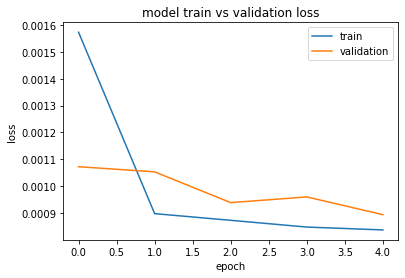

In [13]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# predicting PM10
predicted_y = model.predict(X_test)

# De-normalising predicted y data
predicted_y = i_sc.inverse_transform(predicted_y)
# De-normalising actual y data
y_actual = i_sc.inverse_transform(y_test.reshape(-1,1))

# calculating RMSE
rmse = sqrt(mean_squared_error(y_actual.reshape(-1,1), predicted_y))
rmse


15.459865052176077

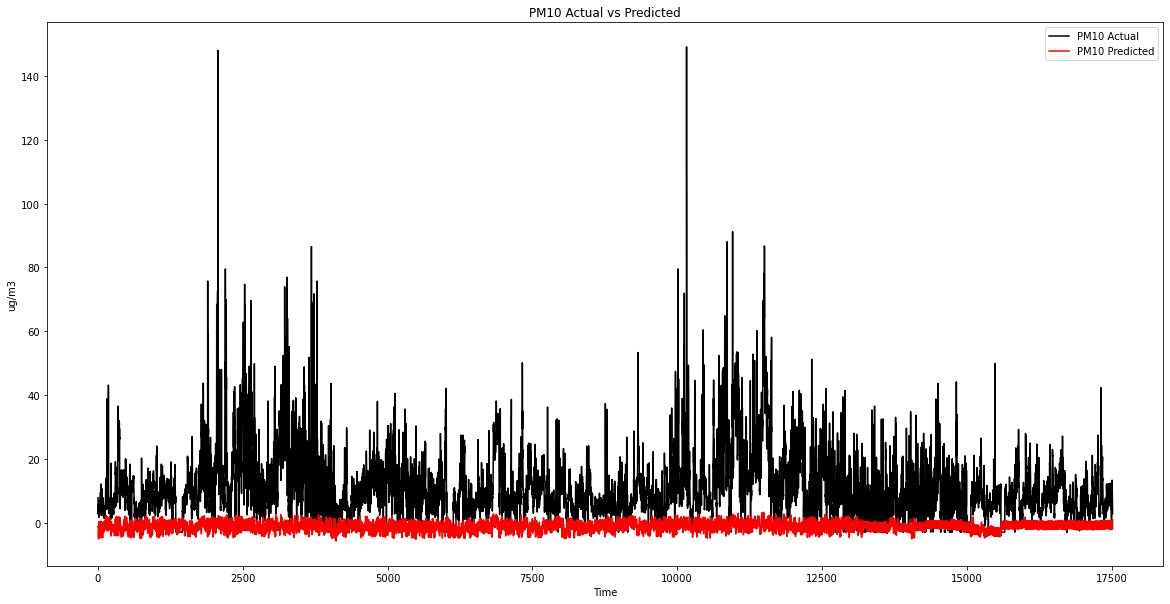

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(y_actual, color = 'black', label = 'PM10 Actual')
plt.plot(predicted_y, color = 'red', label = 'PM10 Predicted')
plt.title('PM10 Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('ug/m3')
plt.legend()
plt.show()

In [45]:
def lstm_fun(model_structure,train_data_shape):
    ## LSTM Architecture
    # input layer
    model = Sequential()
    # Masking Layer
    model.add(Masking(mask_value=-0.00001,input_shape=(train_data_shape[1], train_data_shape[2])))
    for i in list(range(0,len(model_structure))):
        if i != len(model_structure):
            model.add(LSTM(units=model_structure[i],return_sequences = True))
        else:
            model.add(LSTM(units=model_structure[i],return_sequences = False))
    # output layer
    model.add(Dense(units=1))
    # model architecture
    model.summary()
    return(model)

In [59]:
def train_model(model,X_train,y_train,X_test,y_test,model_parameters,denorm_object):
    
    # Compile Model
    model.compile(optimizer = model_parameters[0], loss = model_parameters[1])
    
    # Train the model on the data
    history = model.fit(X_train, y_train, epochs = model_parameters[2],
                        batch_size = model_parameters[3], validation_data= (X_test, y_test))

    # plot train and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # predicting PM10
    predicted_y = model.predict(X_test)

    # De-normalising predicted y data
    predicted_y = denorm_object.inverse_transform(predicted_y.reshape(-1,1))
    print('Predicted: \n', predicted_y[0:5])
    
    # De-normalising actual y data
    y_actual = denorm_object.inverse_transform(y_test.reshape(-1,1))
    print('Actual: \n', y_actual[0:5])

    # calculating RMSE
    rmse = sqrt(mean_squared_error(y_actual.reshape(-1,1), predicted_y))
    print('RMSE: ',rmse)
    
    plt.figure(figsize=(20,10))
    plt.plot(y_actual, color = 'black', label = 'PM10 Actual')
    plt.plot(predicted_y, color = 'red', label = 'PM10 Predicted')
    plt.title('PM10 Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('ug/m3')
    plt.legend()
    plt.show()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_11 (Masking)         (None, 1, 31)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 72)             29952     
_________________________________________________________________
lstm_29 (LSTM)               (None, 1, 72)             41760     
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 72)             41760     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 1)              73        
Total params: 113,545
Trainable params: 113,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
822/822 [==============================] - 80s 97ms/step - loss: 0.0015 - val_loss: 8.9525e-04
Epoch 2/

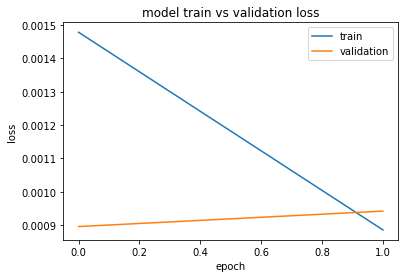

Predicted: 
 [[37.856728 ]
 [ 6.7399917]
 [ 2.7791874]
 [ 3.7339337]
 [ 4.6799283]]
Actual: 
 [[7.8]
 [2.8]
 [4. ]
 [5.2]
 [5.6]]
RMSE:  5.081727769372776


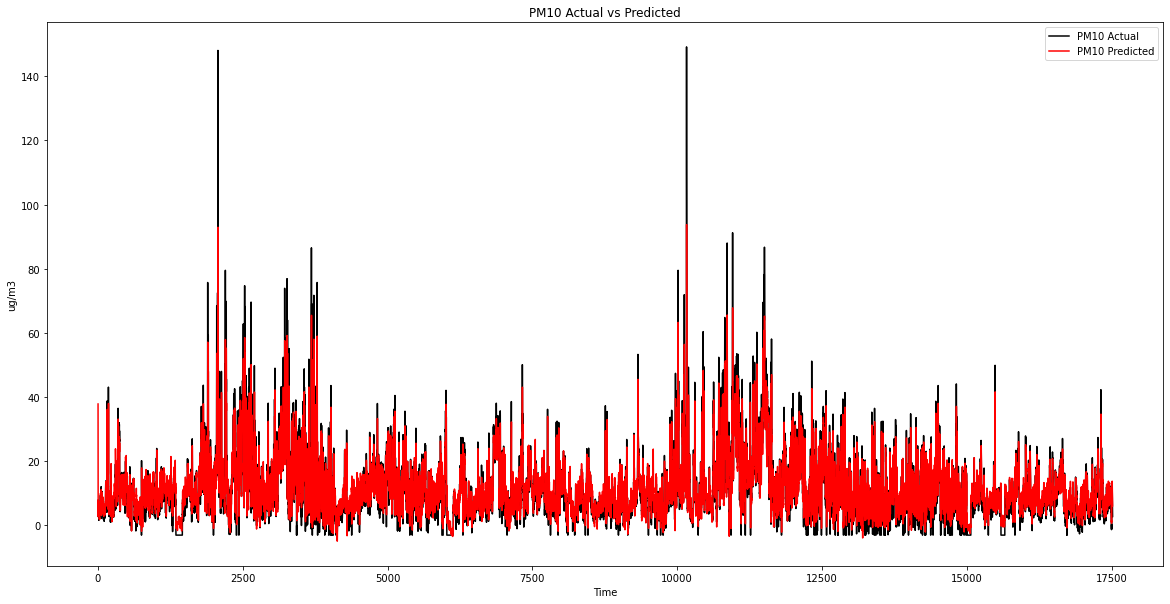

In [60]:
# lstm model layers
Lstm_struct = [72,72,72]
model = lstm_fun(Lstm_struct,X_train.shape)
# parameters for the model optimizer, loss, epoch and batchsize
model_parameters = ['adam','mean_squared_error',2,32]
train_model(model,X_train,y_train,X_test,y_test,model_parameters,i_sc)

In [72]:
def feature_generation(df,selectedStation):
    ## selecting station
    df = df[df['Station Name'] == selectedStation].copy()

    ## convert columns to date
    df['DateTimestamp'] = pd.to_datetime(df['DateTimestamp'])

    ### Adding new Features
    ## Generating weektype from day of week
    df['Weektype'] = pd.DatetimeIndex(df['DateTimestamp']).dayofweek
    # Replace weedays labels WeekDays and WeekEnds 
    df['Weektype'] = df['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
    df['Weektype'] = df['Weektype'].replace([5, 6], 'WeekEnd')

    ## Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
    df = df.assign(Hour=pd.cut(df['DateTimestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
    # Replace timestamp 00:00 with Transition
    df['Hour'] = df['Hour'].fillna('Transition')
    df['Hour'] = df.Hour.astype(str)
    return(df)

In [77]:
selectedStation = "#Stockholm Torkel Knutssongatan"
# input file path
datapath = r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData_metrologicalData.csv"
df = pd.read_csv(datapath)
df = feature_generation(df,selectedStation)

In [78]:
selectedFeatures = ['DateTimestamp','Classification','Weektype','Hour','NOX as NO2','PM10',
                    'Air pressure','Air temperature', 'Amount of clouds', 'Precipitation amount',
                    'Wind direction', 'Wind speed']


## onehot encoding catergories column
df = pd.get_dummies(df[selectedFeatures])

# Generating Year
df['Year'] = df['DateTimestamp'].dt.year

# dropping 2020 data
df = df[df['Year'] != 2020]

# defining the length of the train and test 
train_len = df.loc[df['Year'].isin([2015,2016,2017])].shape[0]
print('Train:',df.loc[df['Year'].isin([2015,2016,2017])].shape[0])
print('Test: ',df.loc[df['Year'].isin([2018,2019])].shape[0])
print(df.info())

Train: 26303
Test:  17520
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43823 entries, 8 to 450634
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DateTimestamp                    43823 non-null  datetime64[ns]
 1   NOX as NO2                       43422 non-null  float64       
 2   PM10                             42112 non-null  float64       
 3   Air pressure                     42318 non-null  float64       
 4   Air temperature                  43818 non-null  float64       
 5   Amount of clouds                 41922 non-null  float64       
 6   Precipitation amount             43806 non-null  float64       
 7   Wind speed                       42318 non-null  float64       
 8   Classification_Urban Background  43823 non-null  uint8         
 9   Weektype_WeekDay                 43823 non-null  uint8         
 10  Weektype_WeekEnd               

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Modyfying data to make it trainable 
# selecting PM10 column
data_set  = df.iloc[:,1:len(df.columns)].values
data_set  = data_set.reshape(-1,len(df.columns)-1)
print("Data Set:\n",data_set[0])
print("Shape:\n",data_set.shape)
print()

# Normalisation of Data
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(data_set)
print("Normalised Data Set:\n",data_set_scaled[0])
print()

# replace nan with -0.00001
data_set_scaled[np.isnan(data_set_scaled)] = -0.00001

# Generating Features and predictions
X = data_set_scaled[0:len(data_set_scaled)-1,:]
y = data_set_scaled[1:len(data_set_scaled),1] # PM10 index 

print("X Shape:\n",X.shape)
print("Y Shape:\n",y.shape)

In [ ]:
## splitting data into test and train
X_train, X_test = X[0:train_len], X[train_len+1:len(X)]
y_train, y_test = y[0:train_len], y[train_len+1:len(X)]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_shape:\n",X_train.shape)
print("y_train_shape:\n",y_train.shape)
print("X_test_shape:\n",X_test.shape)
print("y_test_shape:\n",y_test.shape)

In [92]:
df.iloc[:,1:len(df.columns)].values.shape

(43823, 31)

In [94]:
df.iloc[:,1:len(df.columns)].values.reshape(-1,1,len(df.columns)-1).shape

AttributeError: 'tuple' object has no attribute 'shift'

In [ ]:
X_train = []
y_train = []
# Creating a data structure with n timesteps which is 10 in our example
print(train_size + timesteps)
for i in range(timesteps, train_size + timesteps):
    X_train.append(X_train_set[i-timesteps:i,:])
    y_train.append(y_train_set[i:i+timesteps])
print(“len(X_train)”,len(X_train))
print(“len(y_train)”,len(y_train))

#create X_train matrix
#10 items per array (timestep) 
print(“np.array(X_train).shape=”,np.array(X_train).shape)
print(“X_train[1].shapee=”,X_train[1].shape)
#create Y_train matrix
#10 items per array (as much as timestep) 
print(“y_train[0:2]”,y_train[0:2])
print(“np.array(y_train).shape=”,np.array(y_train).shape)
print(“############################”)
print(“############################”)
print(“############################”)

In [130]:
temp.reshape(5,2,31)

ValueError: cannot reshape array of size 2703876 into shape (5,2,31)

In [144]:
temp = df[['NO2', 'NOX as NO2', 'PM2.5', 'CO', 'Black Carbon', 'O3']].values.copy()
temp[0:5]

array([[ 46.3 , 100.1 ,    nan,    nan,    nan,    nan],
       [  7.5 ,  10.3 ,    nan,   0.15,    nan,    nan],
       [ 23.6 ,  44.9 ,    nan,   0.24,    nan,    nan],
       [  7.4 ,   8.  ,    nan,   0.25,    nan,    nan],
       [ 17.  ,  20.7 ,    nan,   0.26,    nan,    nan]])

In [165]:
temp.reshape(int(len(temp)/14),14,6).shape

(32189, 14, 6)

In [163]:
len(temp)/14

32189.0

In [148]:
2703876/4

675969.0